# Homework 1

In [3]:
#%%module import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from lmfit import Model
from lmfit import Parameters
from scipy.optimize import minimize
from scipy.optimize import fmin_tnc
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold 
from sklearn.metrics import roc_auc_score, f1_score, roc_curve

## Q1

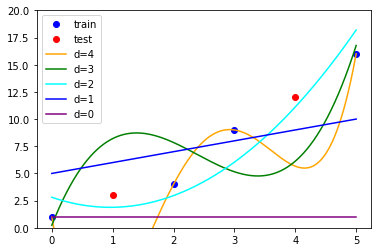

In [4]:
#%% load the data
train=pd.DataFrame([[0,1],[2,4],[3,9],[5,16]])
test=pd.DataFrame([[1,3],[4,12]])

x=train.iloc[:,0].values
y=train.iloc[:,1].values



#%%define the model
#ref for the following: https://stackoverflow.com/questions/48469889/how-to-fit-a-polynomial-with-some-of-the-coefficients-constrained
color_for_degree=["purple","blue","cyan","green","orange"]
coef_name=['a0','a1','a2','a3','a4']

def func(x,a0,a1,a2,a3,a4):
    return a0 + a1*x + a2*x ** 2 + a3*x**3 + a4*x**4 


#fit the model -> plot
    
#%%plot the training and the test points
plt.plot(x, y, 'bo',color="blue")
plt.plot(test.iloc[:,0].values, test.iloc[:,1].values, 'bo',color="red")

#I am able to wrap the following into a for loop by this: https://lmfit.github.io/lmfit-py/parameters.html#lmfit.parameter.Parameters. But I am feeling lazy now


ds=[4,3,2,1,0]
coef_name=['a0','a1','a2','a3','a4']

pmodel = Model(func)
params = Parameters()
results=[]

for d1 in ds:
    for d2 in ds:    
        if d2>d1:
            params.add(coef_name[d2],0)
            params[coef_name[d2]].vary = False
        elif d2==d1:
            params.add(coef_name[d2],1)
            params[coef_name[d2]].vary = False
        else:
            params.add(coef_name[d2],1)
                
    result = pmodel.fit(y, params, x=x)
    results.append(result)
        
    xnew = np.linspace(x[0], x[-1], 1000)
    ynew = result.eval(x=xnew)
            
    plt.ylim(bottom=0, top=20)
    plt.plot(xnew, ynew, 'r-',color=color_for_degree[d1])




#%% show everything
plt.gca().legend(('train','test','d=4','d=3','d=2','d=1','d=0')) #ref: https://stackoverflow.com/questions/19125722/adding-a-legend-to-pyplot-in-matplotlib-in-the-most-simple-manner-possible
plt.show()

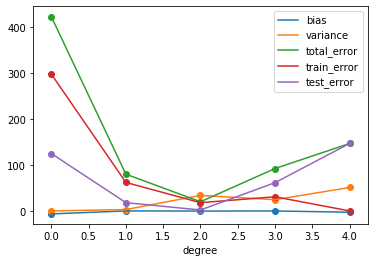

In [5]:
#Ref: https://datascienceomar.wordpress.com/2016/07/03/bias-and-variance-with-scikit-learn-2/

   

x=np.array([0,1,2,3,4,5])
y=np.array([1,3,4,9,12,16])

bias=[]
variance=[]
total_error=[]
train_error=[]
test_error=[]


for d in reversed(ds):
    ##bias = E(f_hat(x)) - E(f(x)) = mean(f_hat(x) -  mean(y))
    y_hat=results[d].eval(x=x)
    
    
    bias.append( np.mean(y_hat-np.mean(y)) )
    
    ##variance=E(f_hat(x)**2)-E(f_hat(x))**2. I don't have the intuitive understanding of the equation. What is it?
    variance.append( np.mean(y_hat**2)-np.mean(y_hat)**2 )
    
    
    ##total error rate = traning error + test error? How do we define test error?
    ##(?)error=RSS
    
    total_error.append( sum( (y-y_hat)**2 ) )
    
    train_error.append( sum( ( (y-y_hat)**2 )[np.array([0,2,3,5])] ) )
    
    test_error.append( sum( ( (y-y_hat)**2 )[np.array([1,4])] ) )


for metric in [bias,variance,total_error,train_error,test_error]:
    plt.scatter(ds,metric)
    plt.plot(ds,metric)
    
    
plt.xlabel('degree')
plt.gca().legend(('bias','variance','total_error','train_error','test_error')) #ref: https://stackoverflow.com/questions/19125722/adding-a-legend-to-pyplot-in-matplotlib-in-the-most-simple-manner-possible
plt.show()

At d=2 it seems to have the best fit because the 5 metrics (bias, variance, total error, training error, test error) are generally smaller than in other degrees. At lower degrees (d=0,1) the models seem to underfit, while on higher degrees (d=3,4) the models seem to overfit (high variance)

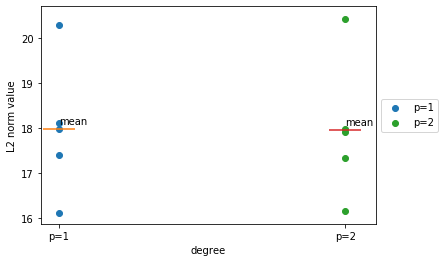

In [6]:
smarket=pd.read_csv("Smarket.csv")
y=smarket['Today'].values
X=smarket[['Lag1','Lag2']].values




def model_func(X,params):
    # 2d Line Z = aX + b
    return X.dot(params[:2]) + params[2]



##have to modify the following code

for p in [1, 2]:
        
    L2_norm=[]
    
    def cost_function(params, X, y, p):
        error_vector = y - model_func(X, params)
        return np.linalg.norm(error_vector, ord=p) #this guy returns the Lp norm

    
    kf=KFold(n_splits=5, random_state=101, shuffle=True)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        output = minimize(cost_function, [1,1,1], args=(X_train, y_train, p)) #[1,1,1] is the initial guess
        L2_norm.append( np.sqrt( sum ( (y_test-model_func(X_test, output.x))**2 ) ) ) #L2 norm = RSS
       
    label='p='+str(p)
    plt.scatter([label]*5,L2_norm,label=label)
    mean=np.mean(L2_norm)
    plt.scatter([label],mean,s=1000,marker="_") #s means size
    plt.annotate('mean',xy=(p-1,mean+0.1))
        
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('degree')
plt.ylabel('L2 norm value')   
plt.show()   

Using L1 or L2 as the minimization method seems to give similar result based on the assesment on the L2 norm value. This is likely because no matter how we change p in Lp norm, the problem stays the same as a linear regression question. Therefore, we don't get significant performace boost by changing the norms

## Q2

![title](Q2.png)

## Q3

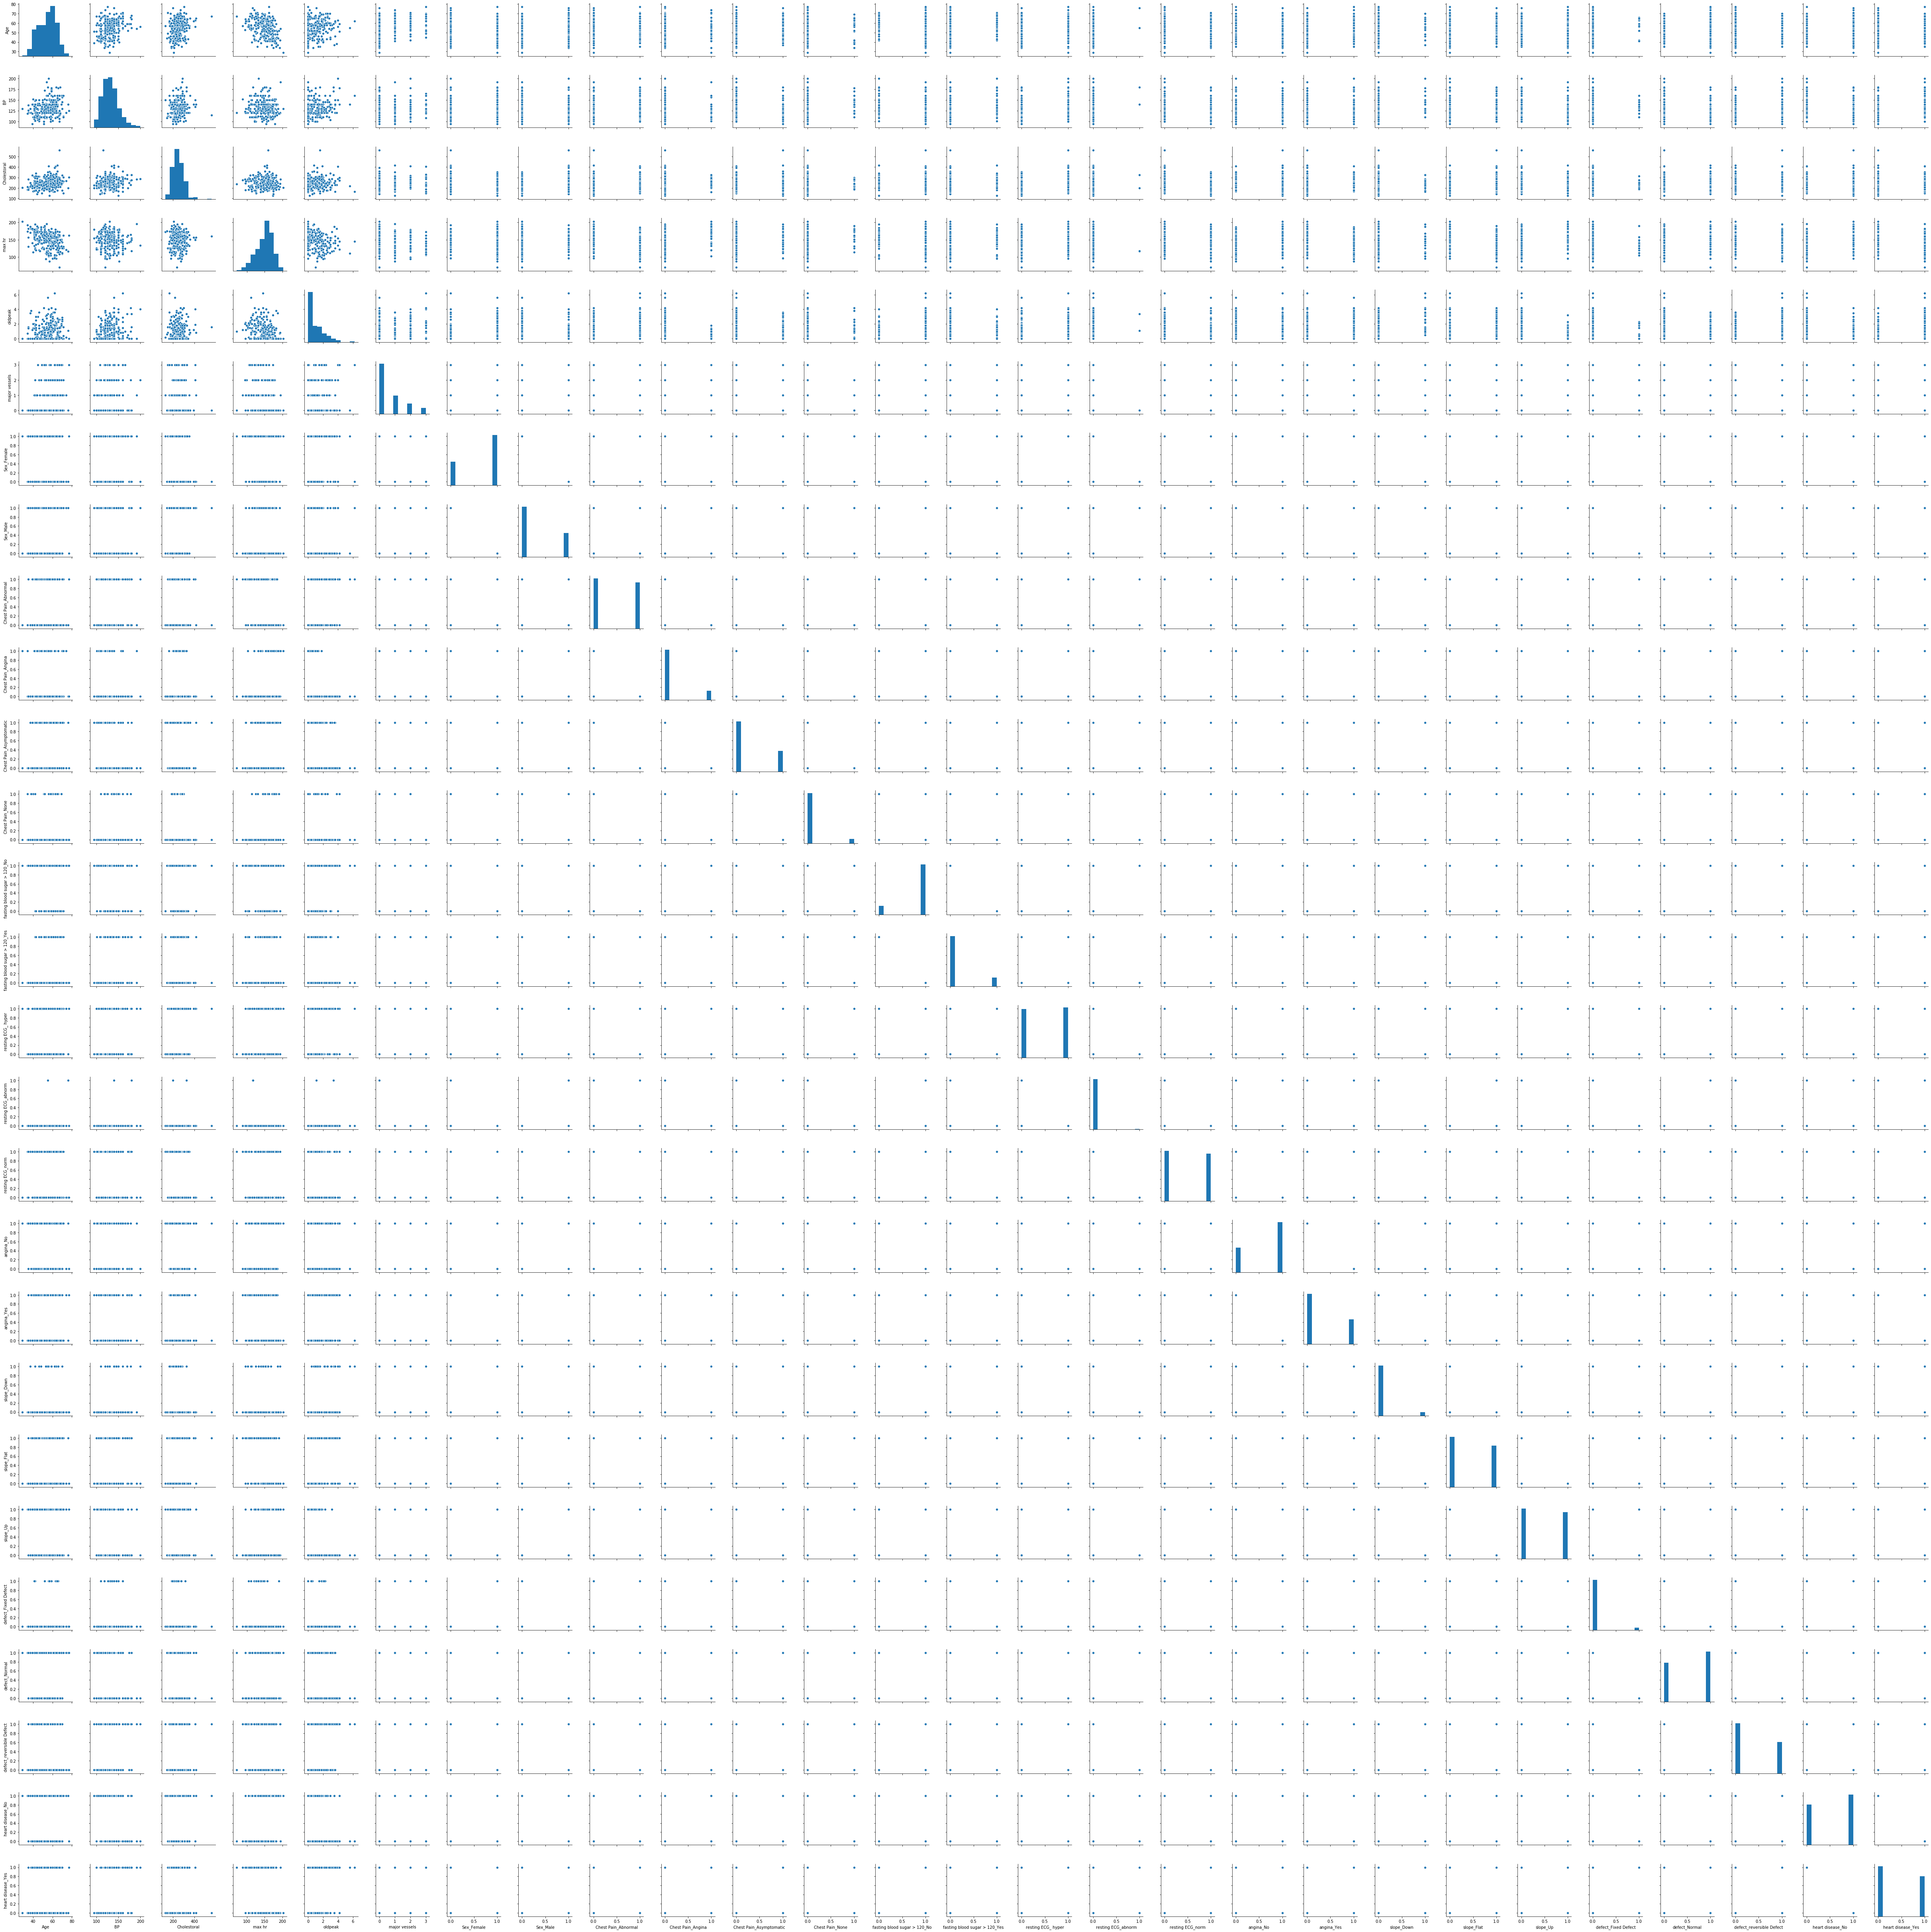

In [9]:
hw1_input=pd.read_csv("hw1_input.csv")
hw1_input.dtypes #14 variables
hw1_input.describe()

new_hw1_input=pd.get_dummies(hw1_input)
new_hw1_input.shape
new_hw1_input.dtypes 

sns.pairplot(new_hw1_input) #scatter plot + histogram

From the above we know:

(1) Age, BP, Cholestoral, max hr, major vessels are discrete variables (integer). 

(2) oldpeak is a continuous variable 

(3) Others columns are categorical variables transformed into multiple dummy variables

In [39]:
import warnings
warnings.filterwarnings('ignore') #I have made sure that all following warnings don't matter, so I will just ignore them.

X = new_hw1_input.iloc[:, 0:-2]
y = hw1_input.iloc[:,-1]
y[y=='Yes']=1
y[y=='No']=0
y=y.astype('int')


ridge_coef=[]
lasso_coef=[]
ridgeAUROC=[]
lassoAUROC=[]
best_ridge_F1=[]
best_lasso_F1=[]
best_ridge_F1_threshold=[]
best_lasso_F1_threshold=[]


for seed in range(1000): #change to 1000 after debugging
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=seed,stratify=y)
    
    #for Ridge
    
    ridge_classifier = RidgeClassifier()
    ridge_classifier.fit(X_train, y_train.values) #ref: https://www.geeksforgeeks.org/numpy-ravel-python/   
    ridge_coef.append(ridge_classifier.coef_[0])
    class_=ridge_classifier.predict(X_test)
    
    #=====In this part I manually calculated the probability because I haven't found a way to output the probabilities
    beta_X=np.dot(ridge_classifier.coef_,np.transpose(X_test))
    probas=np.e**beta_X/(1+np.e**beta_X)
    probas=np.transpose(probas[0].tolist())  
    #=====
          
    
    ridge_F1=[]
    for threshold in probas:
        y_pred=(probas>threshold).astype(int)
        ridge_F1.append(f1_score(y_test, y_pred))

    best_ridge_F1.append(max(ridge_F1))
    best_ridge_F1_threshold.append(probas[ridge_F1.index(max(ridge_F1))])    
    ridgeAUROC.append(roc_auc_score(y_test, ridge_classifier.predict(X_test)))
    
    #get ROC parameter
    if seed==0:
        fpr1, tpr1, thresholds1=roc_curve(y_test,probas)
        auroc1=roc_auc_score(y_test, ridge_classifier.predict(X_test))
        
        
        
    
    #for lasso (not sure how it knows when to use linear regression or logistic regression)
    lasso = Lasso()
    lasso.fit(X_train, y_train)
    lasso_coef.append(lasso.coef_)
    
    probas=lasso.predict(X_test)
    probas=np.transpose(probas.tolist())
    
    lasso_F1=[]
    for threshold in probas:
        y_pred=(probas>threshold).astype(int)
        lasso_F1.append(f1_score(y_test, y_pred))

    best_lasso_F1.append(max(lasso_F1))
    best_lasso_F1_threshold.append(probas[lasso_F1.index(max(lasso_F1))])
    lassoAUROC.append(roc_auc_score(y_test, lasso.predict(X_test)))

    
    #get ROC parameter
    if seed==0:
        fpr2, tpr2, thresholds2=roc_curve(y_test,probas)
        auroc2=roc_auc_score(y_test, lasso.predict(X_test))





### Coefficients

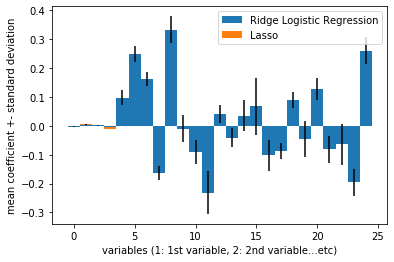

In [42]:
avg_coeff_Ridge = np.mean(ridge_coef, axis = 0).tolist()
std_coeff_Ridge = np.std(ridge_coef, axis = 0).tolist()

avg_coeff_Lasso = np.mean(lasso_coef, axis = 0).tolist()
std_coeff_Lasso = np.std(lasso_coef, axis = 0).tolist()


#ref for the following bargraph: https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/bar_stacked.html
N = X_train.shape[1]
width = 1       # the width of the bars: can also be len(x) sequence
ind = np.arange(N)    # the x locations for the groups
p1 = plt.bar(ind, avg_coeff_Ridge, width, yerr=std_coeff_Ridge,label="Ridge Logistic Regression")
p2 = plt.bar(ind, avg_coeff_Lasso, width,
             bottom=avg_coeff_Ridge, yerr=std_coeff_Lasso,label="Lasso")
plt.legend()
plt.xlabel('variables (1: 1st variable, 2: 2nd variable...etc)')
plt.ylabel('mean coefficient +- standard deviation') 
plt.show()

From the original data, the multi-class columns have been transformed to dummy variables (0,1) in order to implement the regression. It seems for Ridge most of the variables matter, but some coefficients have high standard deviation, indicating that that the values of those variables are not that robust. For Lasso only 3 variables matter (BP, Cholestoral, max hr), yet the corresponding coefficients are relatively small compared to coefficients in Ridge.

### ROC curve

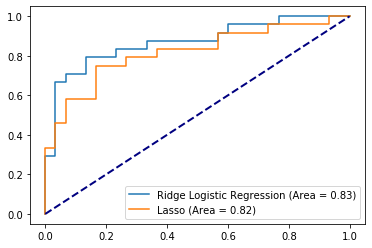

In [43]:
plt.plot(fpr1,tpr1,label="Ridge Logistic Regression (Area = %0.2f)" % auroc1)
plt.plot(fpr2,tpr2,label="Lasso (Area = %0.2f)" % auroc2)
plt.legend()
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.show()

Area = area under the ROC curve (perfect = 1)

### Best threshold for F1

In [44]:
print('Best F1 probability cutoff for Ridge: ',best_ridge_F1_threshold[best_ridge_F1.index(max(best_ridge_F1))])
print('Best F1 probability cutoff for Lasso: ',best_lasso_F1_threshold[best_lasso_F1.index(max(best_lasso_F1))])

Best F1 probability cutoff for Ridge:  0.6167453553701893
Best F1 probability cutoff for Lasso:  0.4452220390013467


### Mean +  Standard deviation for AUROC

In [45]:
print('Mean AUROC for Ridge +- Std: ',np.mean(ridgeAUROC),' + ', np.std(best_ridge_F1))
print('Mean AUROC for Lasso +- Std: ',np.mean(lassoAUROC),' + ', np.std(best_lasso_F1))

Mean AUROC for Ridge +- Std:  0.83705  +  0.04398081291667096
Mean AUROC for Lasso +- Std:  0.7411020833333335  +  0.04206013704000325


### Mean +  Standard deviation for best F1

In [46]:
print('Mean F1 scpre for Ridge +- Std: ',np.mean(best_ridge_F1),' + ', np.std(best_ridge_F1))
print('Mean F1 score for Lasso +- Std: ',np.mean(best_lasso_F1),' + ', np.std(best_lasso_F1))

Mean F1 scpre for Ridge +- Std:  0.8529650861163477  +  0.04398081291667096
Mean F1 score for Lasso +- Std:  0.7121581524949887  +  0.04206013704000325
